In [94]:
# setting environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

From our previous assignment, we have done feature engineering and feature selection of our raw data and exported to csv file.

In [95]:
# read in both raw and clean file
KS_raw = pd.read_csv('data/Kickstarter.csv')
KS_clean = pd.read_csv('data/KS_clean.csv')

In [96]:
KS_clean.head()

,backers_count,disable_communication,goal,is_starrable,staff_pick,state,name_Action,name_Animals,name_Audio,name_Children's Books,...,color_2577151,color_51627,color_58341,color_6526716,location_AU,location_CA,location_DE,location_GB,location_Others,location_US
0,170,0,25000.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,10,0,500.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,3500.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,20000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,62,0,5000.0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [97]:
# Separate groups into training group and testing group by randomly shuffling the index
np.random.seed(1)
random_index = np.random.permutation(KS_clean.index)

In [98]:
random_index

array([1907,  321,  372, ..., 1096,  235, 1061])

In [99]:
stop = int(len(KS_clean)*0.7)
X_train = KS_clean.iloc[random_index[:stop]].drop(['state'], axis=1)
X_test = KS_clean.iloc[random_index[stop:]].drop(['state'], axis=1)
y_train = KS_clean.iloc[random_index[:stop]]['state']
y_test = KS_clean.iloc[random_index[stop:]]['state']

In [100]:
X_train.shape

(2667, 57)

In [101]:
X_test.shape

(1144, 57)

In [102]:
# first classifier, test the Naive Bayes, use the binary/boolean variable(Bernoulli)
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
bnb = BernoulliNB()
not_binary = ['backers_count', 'goal']

# fit our model to the data
bnb.fit(X_train.drop(not_binary, axis=1), y_train)

# use the test set to test our model
prediction = bnb.predict(X_test.drop(not_binary, axis=1))

# compare the real data with prediction
print(accuracy_score(prediction, y_test))

0.791083916083916


In [103]:
# perform cross validation to see if there is any overfitting problem
cross_val_score(bnb, KS_clean.drop(['state'], axis=1), KS_clean['state'], cv=5)

array([0.83355177, 0.81651376, 0.79396325, 0.76115486, 0.78975033])

In [104]:
# check the class imbalance
y_test.value_counts(normalize=True)

0    0.500874
1    0.499126
Name: state, dtype: float64

From above, we could see that successful project consist of about 50% in our test set and the accuracy score is about 79.1%, which is a lot higher than basically predict every project as successful, to dig out more, we will calculate the true positive rate and false positive rate, from investor(backer) perpectives, they would like to use the model to see which project to back, for a more conservative backer, they would like to make sure every dollar they spend on leads to successful project, in other words, they want the false positive rate as low as possible. For a more aggressive backer, they want to back as many successful project as they can, thus they want the true positive rate as high as possible.

In [105]:
# calculate true positive rate and false positive rate
tp = (prediction == 1) & (y_test == 1)
tn = (prediction == 0) & (y_test == 0)
fp = (prediction == 1) & (y_test == 0)
fn = (prediction == 0) & (y_test == 1)
print('True positive rate: {}'.format(np.sum(tp)/(np.sum(tp)+np.sum(fn))))
print('False positive rate: {}'.format(np.sum(fp)/(np.sum(fp)+np.sum(tn))))

True positive rate: 0.7320490367775832
False positive rate: 0.15008726003490402


In [106]:
# second classifier, use the Naive Bayes again, but this time include the numerical variables
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
bnb = MultinomialNB()

# fit our model to the data
bnb.fit(X_train, y_train)

# use the test set to test our model
prediction = bnb.predict(X_test)

# compare the real data with prediction
print(accuracy_score(prediction, y_test))

0.8898601398601399


In [107]:
tp = (prediction == 1) & (y_test == 1)
tn = (prediction == 0) & (y_test == 0)
fp = (prediction == 1) & (y_test == 0)
fn = (prediction == 0) & (y_test == 1)
print('True positive rate: {}'.format(np.sum(tp)/(np.sum(tp)+np.sum(fn))))
print('False positive rate: {}'.format(np.sum(fp)/(np.sum(fp)+np.sum(tn))))

True positive rate: 0.9264448336252189
False positive rate: 0.14659685863874344


From above, we can see that by including the numerical columns and use Multinomial Naive Bayes, we improve our prediction power a lot, not only reflects on the accuracy score but also the True positive rate and False positive rate.

In [108]:
# perform cross validation
cross_val_score(bnb, KS_clean.drop(['state'], axis=1), KS_clean['state'], cv=5)

array([0.9095675 , 0.88990826, 0.91207349, 0.89501312, 0.91064389])

It looks like our second classifier performs pretty well, we will continue to use Naive Bayes, but this time we use Gaussian Naive Bayes, the assumption of this classifier is the features are Gaussian, we will check the distribution of our data feature first

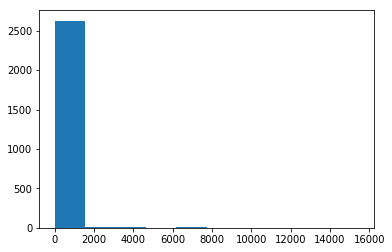

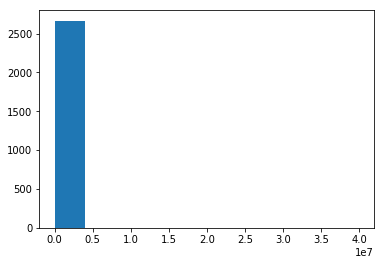

In [109]:
# third classifier, use the Gaussian Naive Bayes
# plot the numerical feature
plt.hist(X_train['backers_count'])
plt.show()
plt.hist(X_train['goal'])
plt.show()

Looks like they are not normal, we need to do some transformation

In [110]:
# perform feature transformation on both train and test set
X_train_g = pd.DataFrame(columns=['backers_count', 'goal'])
X_test_g = pd.DataFrame(columns=['backers_count', 'goal'])
X_train_g['backers_count'] = X_train['backers_count']**0.12
X_test_g['backers_count'] = X_test['backers_count']**0.12
X_train_g['goal'] = X_train['goal']**0.02
X_test_g['goal'] = X_test['goal']**0.02

In [112]:
# third classifier, use the Naive Bayes again, but this time include the numerical variables
from sklearn.naive_bayes import GaussianNB
bnb = GaussianNB()

# fit our model to the data
bnb.fit(X_train_g, y_train)

# use the test set to test our model
prediction = bnb.predict(X_test_g)

# compare the real data with prediction
print(accuracy_score(prediction, y_test))

0.868006993006993


In [113]:
tp = (prediction == 1) & (y_test == 1)
tn = (prediction == 0) & (y_test == 0)
fp = (prediction == 1) & (y_test == 0)
fn = (prediction == 0) & (y_test == 1)
print('True positive rate: {}'.format(np.sum(tp)/(np.sum(tp)+np.sum(fn))))
print('False positive rate: {}'.format(np.sum(fp)/(np.sum(fp)+np.sum(tn))))

True positive rate: 0.9527145359019265
False positive rate: 0.2164048865619546


We can see that the performance of GaussianNB lies between BernoulliNB and MultinomialNB, however the False positive rate is higher than the other two, which shows GaussianNB might not be a good model for conservative backer

In [114]:
# for curiocity, test GaussianNB without transformation
# fit our model to the data
bnb.fit(X_train[['backers_count', 'goal']], y_train)

# use the test set to test our model
prediction = bnb.predict(X_test[['backers_count', 'goal']])

# compare the real data with prediction
print(accuracy_score(prediction, y_test))

0.5620629370629371


In [115]:
tp = (prediction == 1) & (y_test == 1)
tn = (prediction == 0) & (y_test == 0)
fp = (prediction == 1) & (y_test == 0)
fn = (prediction == 0) & (y_test == 1)
print('True positive rate: {}'.format(np.sum(tp)/(np.sum(tp)+np.sum(fn))))
print('False positive rate: {}'.format(np.sum(fp)/(np.sum(fp)+np.sum(tn))))

True positive rate: 0.9982486865148862
False positive rate: 0.8726003490401396


From above, we can see that without transforming the features to meet the assumption of GaussianNB, the model performs poorly 

Finally, we will use the logistic regression model to see its performance

In [116]:
# classifier four, logistic regression model
from sklearn import linear_model
regr = linear_model.LogisticRegression()

# fit the model
regr.fit(X_train, y_train)

# use the test set to test our model
prediction = regr.predict(X_test)

# compare the real data with prediction
print(accuracy_score(prediction, y_test))

0.9055944055944056


In [117]:
tp = (prediction == 1) & (y_test == 1)
tn = (prediction == 0) & (y_test == 0)
fp = (prediction == 1) & (y_test == 0)
fn = (prediction == 0) & (y_test == 1)
print('True positive rate: {}'.format(np.sum(tp)/(np.sum(tp)+np.sum(fn))))
print('False positive rate: {}'.format(np.sum(fp)/(np.sum(fp)+np.sum(tn))))

True positive rate: 0.9527145359019265
False positive rate: 0.14136125654450263


From above, we can see that logistic regression model outperforms Naive Bayes in almost every aspect, it has high accuracy score, high True positive rate as well as low False positive rate, this is our ideal model to predict whether the project will be successful or not before deciding to back it.

In [118]:
# we will do another cross validation to see if our model overfits
cross_val_score(regr, KS_clean.drop(['state'], axis=1), KS_clean['state'], cv=5)

array([0.91349934, 0.90039318, 0.92388451, 0.90944882, 0.91721419])

We can see that the score is very consistent in each iteration, the future step may include using another dataset to test our model